In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
os.environ["OMP_NUM_THREADS"] = "5"

In [2]:
df = pd.read_csv('./../CSVs/Battery and e-waste collection centers USA.csv')
df[['lon', 'lat']] = df['WKT'].str.extract(r'POINT \(([^ ]+) ([^)]+)\)').astype(float)
df

,WKT,name,lon,lat
0,POINT (-118.3514773 34.0412734),"A1 Electronic Recycling,",-118.351477,34.041273
1,POINT (-118.42281 34.204152),"eWaste U.S. Electronics Recycling,",-118.422810,34.204152
2,POINT (-118.6000354 34.2135694),"CAL E-WASTE RECYCLE LLC,",-118.600035,34.213569
3,POINT (-118.4856892 34.2018167),"E -Waste LA (Data Destruction Company),",-118.485689,34.201817
4,POINT (-118.4168123 34.2606906),"pasadena tech recycle inc,",-118.416812,34.260691
...,...,...,...,...
59,POINT (-115.129013 35.987648),"PedalPoint evTerra Recycling,",-115.129013,35.987648
60,POINT (-115.1854335 36.078715),"BB Recycling,",-115.185434,36.078715
61,POINT (-115.0950232 36.2437766),"Nevada Recycling,",-115.095023,36.243777
62,POINT (-115.193616 36.0451545),"Advanced Technology Recycling (ATR),",-115.193616,36.045155


In [3]:
rad_lat = np.radians(df['lat'])
rad_lon = np.radians(df['lon'])

df['x'] = np.cos(rad_lat) * np.cos(rad_lon)
df['y'] = np.cos(rad_lat) * np.sin(rad_lon)
df['z'] = np.sin(rad_lat)

In [4]:
m = folium.Map([33.447046773463654, -112.08091337731709], zoom_start=12)

def mark_on_map(row):
  lat = row['lat']
  lon = row['lon']
  
  folium.Marker(
    location=[lat, lon],
    popup=row['name'],
    icon=folium.Icon("red")
  ).add_to(m)
  
df.apply(mark_on_map, axis=1)

0     None
1     None
2     None
3     None
4     None
      ... 
59    None
60    None
61    None
62    None
63    None
Length: 64, dtype: object

In [5]:
X = df[['x', 'y', 'z']]

In [6]:
k_values = range(2, 60)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

Silhouette Score: 0.1562


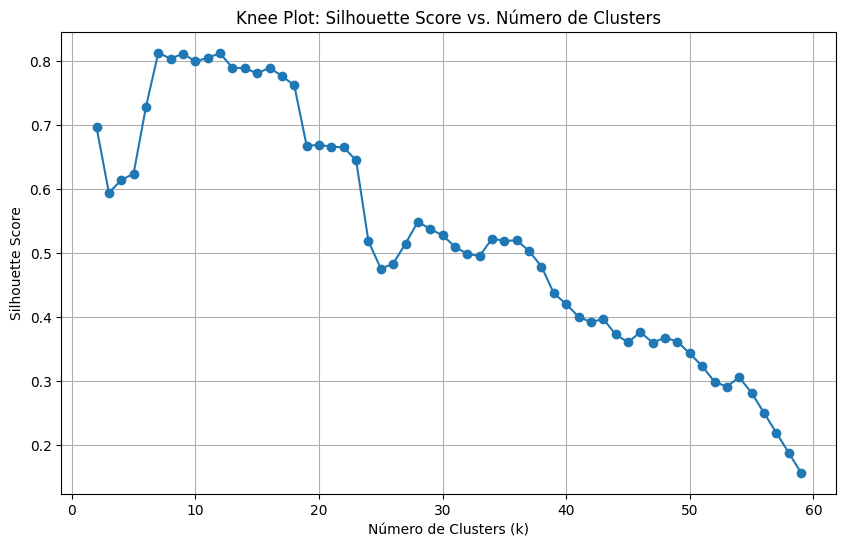

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Knee Plot: Silhouette Score vs. Número de Clusters')
plt.grid(True)
plt.show()

In [ ]:
k=25
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)
sil_score = silhouette_score(X, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")